# Stochastic Physics-Informed Neural ODEs (SPINODE)

A few key notes:

(1) The code here is tailored to learn neural network representations of hidden physics within stochastic differential equations of the form:

$$ dx = g_1(x,u)dt + \sqrt{2g_2(x,u)} dw, $$

where where $x$ is the system state, $u$ is an exogenous input, $w$ is a Gaussian white noise process, $g_1$ is the drift coefficient, and $g_2$ is the diffusion coefficient. Although the drift and diffusion coefficients represent the underlying physics of the stochastic system, these coefficients may not be known or even measurable in practice. As a result, $g_1$, $g_2$, or individual functions that contribute to $g_1$ and $g_2$ can comprise the the hidden physics of the above equation.

(2) The code uses unscented transform to propagate stochasticity through the above equations although other uncertainty propagation methods can be integrated into the code.

(3) Example data and results are provided for the first case study from the original paper (O'Leary et al., 2022) in the file Data.zip. The first case study is a two-state model for directed colloidal self-assembly with an exogenous input.

In [1]:
# Do not write bytecode to maintain clean directories
import sys
sys.dont_write_bytecode = True

# Import required packages and core code
import numpy as np
import os
import torch

# Ruta al directorio raíz del repo (dos niveles hacia arriba desde experiments/BS)
repo_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))

# Agregar el root al sys.path si no está
if repo_root not in sys.path:
    sys.path.append(repo_root)

import src.train as train

# Specify GPU or CPU use
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# Load moment data
# Mean data must be of shape [N, [nx,nu], 1]
# Covariance data must be of shape [N, nx, nx]
# Note that the general methodology can handle higher moments
# --> This code, however, only uses mean and covariance data

mean_i = np.load("data/mean_initial.npy") # mean at time step k
mean_f = np.load("data/mean_final.npy") # mean at time step k + 1
cov_i = np.load("data/cov_initial.npy") # covariance at time step k
cov_f = np.load("data/cov_final.npy") # covariance at time step k + 1

In [3]:
# Fix shapes for 1D systems
mean_i = mean_i.reshape(mean_i.shape[0], 1, 1)
mean_f = mean_f.reshape(mean_f.shape[0], 1, 1)
cov_i  = cov_i.reshape(cov_i.shape[0], 1, 1)
cov_f  = cov_f.reshape(cov_f.shape[0], 1, 1)

In [4]:
# Enter relevant system information
nx = 1 # state dimension
nw = 1 # noise dimension
n = nx + nw # augmented state dimension
nu = 0 # exogenous input dimension
dt = 1/252 # sampling time

In [5]:
# Prepare some of the data used to train the neural networks
# that approximate the hidden physics. Note that the "sigma" points come from
# the unscented transform function defined in "utils.py"

# First choose and create path where data will be saved
path = "results/"
os.makedirs(path, exist_ok=True)

# Now prepare data
[sigma_train,
 sigma_val,
 sigma_test,
 mean_f_train,
 mean_f_val,
 mean_f_test,
 cov_f_train,
 cov_f_val,
 cov_f_test,
 W_train,
 W_val,
 W_test,
 sigma_mu,
 sigma_std] = train.prep_data(mean_i,
                              cov_i,
                              mean_f,
                              cov_f,
                              nx,
                              nu,
                              nw,
                              path)

In [6]:
# Set training parameters for neural network that approximates g1
hidden_dim_g1 = 100 # number of hidden nodes
num_hidden_layers_g1 = 2 # number of hidden layers
num_epoch_g1 = 500 # number of epochs
solver_g1 = 'euler' # ode solver
# Note that for the provided data, the 'euler' ODE solver performs the best.
# See O'Leary, et al., 2022 for more details
rtol_g1 = 1e-7 # default value 1e-7
atol_g1 = 1e-9 # default value 1e-9

In [7]:
# Train neural network that approximates g1
model_g1 = train.train_g1(hidden_dim_g1,
                          num_hidden_layers_g1,
                          device,
                          nx,
                          nu,
                          dt,
                          num_epoch_g1,
                          sigma_train,
                          sigma_val,
                          mean_f_train,
                          mean_f_val,
                          W_train,
                          W_val,
                          solver_g1,
                          rtol_g1,
                          atol_g1,
                          path)

Epoch 0000 | Train Loss 0.000000518 | Val Loss 0.000000673
0.07374858856201172
Epoch 0001 | Train Loss 0.000000408 | Val Loss 0.000000556
0.027028799057006836
Epoch 0002 | Train Loss 0.000000390 | Val Loss 0.000000438
0.02603006362915039
Epoch 0003 | Train Loss 0.000000302 | Val Loss 0.000000324
0.026546478271484375
Epoch 0004 | Train Loss 0.000000205 | Val Loss 0.000000242
0.02804279327392578
Epoch 0005 | Train Loss 0.000000198 | Val Loss 0.000000184
0.02829599380493164
Epoch 0006 | Train Loss 0.000000170 | Val Loss 0.000000148
0.027036190032958984
Epoch 0007 | Train Loss 0.000000120 | Val Loss 0.000000130
0.031583547592163086
Epoch 0008 | Train Loss 0.000000111 | Val Loss 0.000000124
0.031487226486206055
Epoch 0009 | Train Loss 0.000000126 | Val Loss 0.000000127
0.03212571144104004
Epoch 0010 | Train Loss 0.000000116 | Val Loss 0.000000126
0.02655935287475586
Epoch 0011 | Train Loss 0.000000105 | Val Loss 0.000000124
0.02664971351623535
Epoch 0012 | Train Loss 0.000000138 | Val Loss 

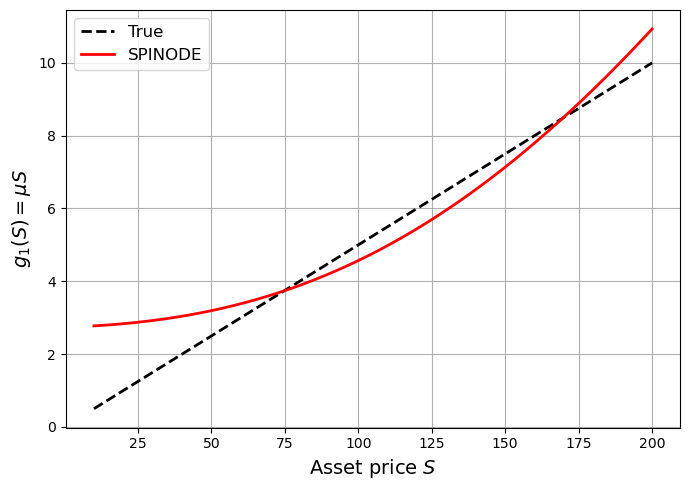

RMSE(g1) = 7.981134e-01


In [8]:
# Reconstruct g1
rmse_g1 = train.reconstruct_BS('g1',
                               model_g1,
                               device,
                               sigma_mu,
                               sigma_std,
                               nx,
                               nu,
                               dt,
                               path)

In [9]:
# Set training parameters for neural network that approximates g2
hidden_dim_g2 = 100 # number of hidden nodes
num_hidden_layers_g2 = 2 # number of hidden layers
num_epoch_g2 = 500 # number of epochs
solver_g2 = 'euler' # ode solver
# Note that for the provided data, the 'euler' ODE solver performs the best.
# See O'Leary, et al., 2022 for more details
rtol_g2 = 1e-15 # default value 1e-7
atol_g2 = 1e-15 # default value 1e-9

In [10]:
# Prepare target data for training neural network that approximates g2
[g2_target_train,
 g2_target_val,
 g2_target_test] = train.calc_g2_targets(sigma_train,
                                         sigma_val,
                                         sigma_test,
                                         mean_f_train,
                                         mean_f_val,
                                         mean_f_test,
                                         cov_f_train,
                                         cov_f_val,
                                         cov_f_test,
                                         nx,
                                         nu,
                                         nw,
                                         dt,
                                         sigma_mu,
                                         sigma_std,
                                         W_train,
                                         W_val,
                                         W_test,
                                         model_g1,
                                         device,
                                         solver_g1,
                                         rtol_g1,
                                         atol_g1,
                                         path)

In [11]:
# Train neural network that approximates g2
model_g2 = train.train_g2(hidden_dim_g2,
                          num_hidden_layers_g2,
                          device,
                          nx,
                          nu,
                          dt,
                          num_epoch_g2,
                          sigma_train,
                          sigma_val,
                          g2_target_train,
                          g2_target_val,
                          solver_g2,
                          rtol_g2,
                          atol_g2,
                          path)

Epoch 0000 | Train Loss 0.001189623 | Val Loss 0.002126466
0.008001565933227539
Epoch 0001 | Train Loss 0.001288008 | Val Loss 0.002100269
0.007445573806762695
Epoch 0002 | Train Loss 0.001227987 | Val Loss 0.002073283
0.006028413772583008
Epoch 0003 | Train Loss 0.001708656 | Val Loss 0.002046406
0.007508039474487305
Epoch 0004 | Train Loss 0.001372316 | Val Loss 0.002019029
0.0070078372955322266
Epoch 0005 | Train Loss 0.001204343 | Val Loss 0.001990709
0.0075109004974365234
Epoch 0006 | Train Loss 0.001164255 | Val Loss 0.001961317
0.006508827209472656
Epoch 0007 | Train Loss 0.001263061 | Val Loss 0.001930678
0.006999492645263672
Epoch 0008 | Train Loss 0.001207076 | Val Loss 0.001898147
0.005514621734619141
Epoch 0009 | Train Loss 0.001328576 | Val Loss 0.001863667
0.006506204605102539
Epoch 0010 | Train Loss 0.001106524 | Val Loss 0.001827097
0.007010459899902344
Epoch 0011 | Train Loss 0.001122467 | Val Loss 0.001788635
0.006510019302368164
Epoch 0012 | Train Loss 0.001110586 | 

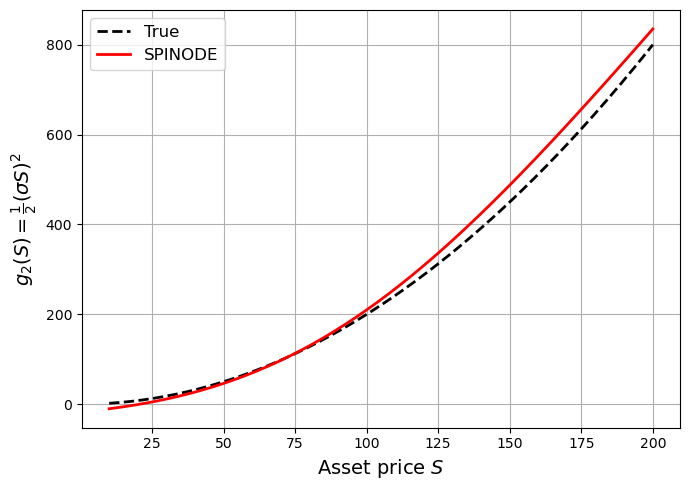

RMSE(g2) = 2.509687e+01


In [12]:
# Reconstruct g2
rmse_g2 = train.reconstruct_BS('g2',
                                model_g2,
                                device,
                                sigma_mu,
                                sigma_std,
                                nx,
                                nu,
                                dt,
                                path)

In [13]:
rmse_g1 = np.load("results/rmse_g1_BS.npy")
rmse_g2 = np.load("results/rmse_g2_BS.npy")
print("RMSE(g1):", rmse_g1)
print("RMSE(g2):", rmse_g2)

RMSE(g1): 0.798113441600458
RMSE(g2): 25.096868367285598
